In [1]:
import deepkt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as ac; ac.set_theme()
import scipy.stats as st
from sci_analysis import analyze
import pandas as pd
import bnlearn as bn
from scipy.special import expit
import matplotlib
import pgmpy

In [2]:
fn = "data/moocData.csv" # Dataset path
verbose = 1 # Verbose = {0,1,2}
best_model_weights = "weights/bestmodel" # File to save the model.
log_dir = "logs" # Path to save the logs.
optimizer = "adam" # Optimizer to use
lstm_units = 100 # Number of LSTM units
batch_size = 32 # Batch size
epochs = 50 # Number of epochs to train
dropout_rate = 0.4 # Dropout rate
test_fraction = 0.2 # Portion of data to be used for testing
validation_fraction = 0.2 # Portion of training data to be used for validation

In [11]:
from deepkt import deepkt, data_util, metrics

# batch_size=1
dataset, length, nb_features, nb_skills = data_util.load_dataset(fn=fn,
                                                                 batch_size=batch_size,
                                                                 shuffle=True)

train_set, test_set, val_set = data_util.split_dataset(dataset=dataset,
                                                       total_size=length,
                                                       test_fraction=test_fraction,
                                                       val_fraction=validation_fraction)


set_sz = length * batch_size
test_set_sz = (set_sz * test_fraction)
val_set_sz = (set_sz - test_set_sz) * validation_fraction
train_set_sz = set_sz - test_set_sz - val_set_sz
print("============= Data Summary =============")
print("Total number of students: %d" % set_sz)
print("Training set size: %d" % train_set_sz)
print("Validation set size: %d" % val_set_sz)
print("Testing set size: %d" % test_set_sz)
print("Number of skills: %d" % nb_skills)
print("Number of features in the input: %d" % nb_features)
print("========================================")

============= Data Summary =============
Total number of students: 1529
Training set size: 978
Validation set size: 244
Testing set size: 305
Number of skills: 170
Number of features in the input: 340


In [4]:
#batch_size=1

train_length=train_set_sz // batch_size
val_length=val_set_sz // batch_size

student_model = deepkt.DKTModel(
                        nb_features=nb_features,
                        nb_skills=nb_skills,
                        hidden_units=lstm_units,
                        dropout_rate=dropout_rate)

student_model.compile(
        optimizer=optimizer,
        metrics=[
            metrics.BinaryAccuracy(),
            metrics.AUC(),
            metrics.Precision(),
            metrics.Recall()
        ])

student_model.summary()

Model: "DKTModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 340)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 340)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         176400    
_________________________________________________________________
outputs (TimeDistributed)    (None, None, 170)         17170     
Total params: 193,570
Trainable params: 193,570
Non-trainable params: 0
_________________________________________________________________


In [5]:
import tensorflow as tf
history = student_model.fit(dataset=train_set,
                            epochs=epochs,
                            verbose=verbose,
                            validation_data=val_set,
                            callbacks=[
                                tf.keras.callbacks.CSVLogger(f"{log_dir}/train.log"),
                                tf.keras.callbacks.ModelCheckpoint(best_model_weights,
                                                                   save_best_only=True,
                                                                   save_weights_only=True),
                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)
        ])

Epoch 1/50


2022-06-04 10:40:39.770684: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_3540_4137_specialized_for_training_Adam_gradients_gradients_lstm_StatefulPartitionedCall_grad_StatefulPartitionedCall_at___inference_keras_scratch_graph_4789' and '__inference___backward_cudnn_lstm_with_fallback_785_2242' both implement 'lstm_f04a6864-ba35-4689-9da9-6d345861280a' but their signatures do not match.


      1/Unknown - 3s 3s/step - loss: 0.1650 - binary_accuracy: 0.5114 - auc: 0.5207 - precision: 0.7641 - recall: 0.5117

2022-06-04 10:40:40.535318: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


29/29 [==============================] - 12s 429ms/step - loss: 0.1756 - binary_accuracy: 0.7213 - auc: 0.6206 - precision: 0.7900 - recall: 0.8599 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
29/29 [==============================] - 7s 253ms/step - loss: 0.1388 - binary_accuracy: 0.7737 - auc: 0.6899 - precision: 0.7967 - recall: 0.9406 - val_loss: 0.1326 - val_binary_accuracy: 0.7915 - val_auc: 0.7243 - val_precision: 0.8202 - val_recall: 0.9401
Epoch 3/50
29/29 [==============================] - 8s 259ms/step - loss: 0.1321 - binary_accuracy: 0.7786 - auc: 0.7276 - precision: 0.7972 - recall: 0.9483 - val_loss: 0.1301 - val_binary_accuracy: 0.7917 - val_auc: 0.7356 - val_precision: 0.8228 - val_recall: 0.9358
Epoch 4/50
29/29 [==============================] - 7s 256ms/step - loss: 0.1294 - binary_accuracy: 0.7796 - auc: 0.7446 - precision: 0.7972 - recall: 0.9502 - val_loss: 0.1275 - v

In [6]:
student_model.load_weights(best_model_weights)

In [7]:
result = student_model.evaluate(test_set, verbose=verbose)

     10/Unknown - 1s 115ms/step - loss: 0.1186 - binary_accuracy: 0.8117 - auc: 0.8306 - precision: 0.8315 - recall: 0.9375

#### Take One Sample

In [4]:
iter = test_set.make_one_shot_iterator()
iter.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(<tf.Tensor: id=72, shape=(1, 4, 340), dtype=float32, numpy=
 array([[[0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>,
 <tf.Tensor: id=73, shape=(1, 4, 171), dtype=float32, numpy=
 array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.,

In [90]:
tf.data.experimental.get_single_element(dataset[0])

TypeError: 'DatasetV1Adapter' object is not subscriptable

In [8]:
def get_element_by_index(data_set,candidate_index):
    """
    This function gets candidate
    by index
    """
    for raw_index,candidate in enumerate(data_set):

        if raw_index == candidate_index:
            candidate_desired = candidate
            return candidate_desired




In [17]:
a=get_element_by_index(test_set,0)
a


(<tf.Tensor: id=198163, shape=(1, 4, 340), dtype=float32, numpy=
 array([[[0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>,
 <tf.Tensor: id=198164, shape=(1, 4, 171), dtype=float32, numpy=
 array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.,

In [10]:
tf.slice(test_set,[0],[0])

ValueError: Attempt to convert a value (<DatasetV1Adapter shapes: ((1, None, None), (1, None, None)), types: (tf.float32, tf.float32)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>) to a Tensor.

In [100]:
tf.reshape(a[0][0][0:2], [1, 2,340])

<tf.Tensor: id=2461446, shape=(1, 2, 340), dtype=float32, numpy=
array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [99]:
a[0][0][0].reshape

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'reshape'

## Error Calculation for Whole Test Set
#### Algorithm-1

In [12]:

y_gr_lst=[]
err_calculation_matrix=np.zeros((170,1))
err_counter_matrix=np.zeros((170,1))

for i in range(int(test_set_sz)):
    if i== 210:
        continue
    student_desired=get_element_by_index(test_set,i)

    #student array
    tmp_s=student_desired[0][0]
    l,_=tmp_s.shape
    tmp_y_gr=np.zeros((170,1))
    #calculate ground truth
    #begin
    for j in range(l):
        tmp_index=np.where(tmp_s[j] == 1)[0][0]
        real_index=int(tmp_index/2)
        real_val=tmp_index%2
        tmp_y_gr[j]=real_val
    #end
    #make prediction
    #begin
    err_list_total=[]
    for k in range(l):
        s1=tf.reshape(student_desired[0][0][0:k+1], [1, k+1,340])
        pr=student_model.predict(s1)
        x,y,z = pr.shape
        total=0
        for a in range(y):
            total=abs(pr[0][a][a]-tmp_y_gr[a])+total
        err_calculation_matrix[k]=err_calculation_matrix[k]+total/y
        err_counter_matrix[k]=err_counter_matrix[k]+1
        # err_list_total.append(total/y)
    #end

IndexError: index 170 is out of bounds for axis 0 with size 170

In [19]:
err_calculation_matrix/err_counter_matrix

array([[0.25425145],
       [0.15349195],
       [0.15809734],
       [0.23328961],
       [0.26208079],
       [0.25278614],
       [0.25319658],
       [0.25308917],
       [0.2436357 ],
       [0.24451515],
       [0.26081789],
       [0.25193373],
       [0.25711766],
       [0.25443548],
       [0.26049395],
       [0.26328881],
       [0.26687842],
       [0.27185144],
       [0.27685643],
       [0.27479978],
       [0.27606864],
       [0.2739225 ],
       [0.27085287],
       [0.27322073],
       [0.2768095 ],
       [0.27303558],
       [0.26752904],
       [0.26006881],
       [0.25588779],
       [0.25803127],
       [0.25615055],
       [0.25729401],
       [0.25418062],
       [0.25140104],
       [0.24511169],
       [0.24396385],
       [0.24151987],
       [0.23981185],
       [0.24011855],
       [0.24051772],
       [0.24068131],
       [0.23996818],
       [0.24463835],
       [0.24703374],
       [0.2513029 ],
       [0.25033666],
       [0.24656747],
       [0.248

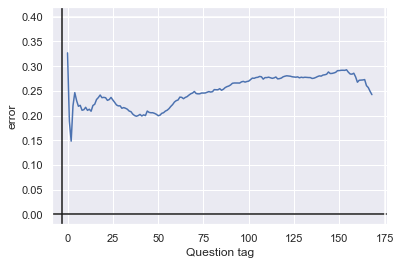

In [13]:
plt.plot((err_calculation_matrix/err_counter_matrix))
plt.ylabel('error')
plt.xlabel('Question tag')
plt.axhline(y=0, color='k')
plt.axhline(y=0.4, color='w')
plt.axvline(x=-3, color='k')
plt.axvline(x=175, color='w')
plt.show()

In [34]:
a2=[4,28,44,52,62,68,70,81,91,109,122,132,145,169]
err_=err_calculation_matrix/err_counter_matrix
err_=np.nan_to_num(err_)
a1=np.zeros((170,1))
a1[0:10]=1
a1[0:10]
flr=0
for i in a2:
    ciel=i+1

    val=sum(err_[flr :ciel])/(ciel-flr)
    a1[flr :ciel]=val
    flr=ciel


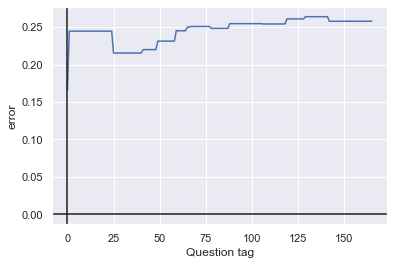

In [37]:
plt.plot(a1[4:])
plt.ylabel('error')
plt.xlabel('Question tag')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

In [111]:
s1=get_element_by_index(test_set,0)
s1[0]

<tf.Tensor: id=1160545, shape=(1, 28, 340), dtype=float32, numpy=
array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [112]:
y_hat=(pr[25]).reshape((170, 1))
(y_hat>0.5).astype(float)
#sum(abs(y_hat-tmp_y_hat)/28)

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],

In [113]:
s1=get_element_by_index(test_set,0)
#student array
s1=s1[0]
s1=tf.expand_dims(s1, axis=0)
pr=student_model.predict(tf.squeeze(s1,axis=0))[0]
pr #prediction of last time step

array([[0.7532529 , 0.9722309 , 0.9140054 , ..., 0.59316874, 0.38260174,
        0.32693607],
       [0.8144911 , 0.9829453 , 0.9494324 , ..., 0.61384165, 0.30708206,
        0.25380152],
       [0.8184097 , 0.96581846, 0.9246145 , ..., 0.59320796, 0.3081843 ,
        0.26353008],
       ...,
       [0.9013619 , 0.8404461 , 0.7746472 , ..., 0.44198036, 0.12963176,
        0.20696291],
       [0.9357399 , 0.8595221 , 0.7679024 , ..., 0.44657147, 0.1096614 ,
        0.16757873],
       [0.918663  , 0.82648903, 0.68867713, ..., 0.4279492 , 0.12361372,
        0.21098706]], dtype=float32)

In [20]:
def return_question_sample_correct(end):
    dummy_input=np.zeros((1,end,340))
    for i in range (end):
        dummy_input[0][i][2*i+1] = 1
    return dummy_input

In [17]:
return_question_sample_correct(1)


(1, 1, 340)


In [23]:
from tensorflow_core import float32
three_question=return_question_sample_correct(3)
three_answer_tensor = tf.convert_to_tensor(three_question,dtype=float32)
three_answer_prediction = student_model.predict(three_answer_tensor)
three_answer_prediction

2022-06-02 20:20:21.658412: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_445' and '__inference_standard_lstm_445_specialized_for_lstm_StatefulPartitionedCall_at___inference_keras_scratch_graph_3777' both implement 'lstm_e2e14f61-2e05-4221-a80d-70d6ea1ba70b' but their signatures do not match.


array([[[0.62325853, 0.9539352 , 0.8438508 , 0.55322415, 0.54587233,
         0.59817576, 0.6161396 , 0.58230364, 0.5922155 , 0.58940345,
         0.5708336 , 0.59386027, 0.5486519 , 0.59601235, 0.53107476,
         0.5583892 , 0.5523021 , 0.52470064, 0.5276731 , 0.5710209 ,
         0.51084065, 0.5672042 , 0.5618749 , 0.5241984 , 0.5398346 ,
         0.59090304, 0.5797907 , 0.6400257 , 0.5793313 , 0.5537494 ,
         0.59779334, 0.549143  , 0.5776883 , 0.58872086, 0.5972203 ,
         0.56135404, 0.55003464, 0.54795086, 0.56609404, 0.52353024,
         0.49806187, 0.54730576, 0.51814246, 0.4961898 , 0.50036067,
         0.5883384 , 0.6120232 , 0.5372505 , 0.56182766, 0.5639722 ,
         0.5623366 , 0.5155323 , 0.52099854, 0.5098855 , 0.5199457 ,
         0.55548745, 0.45876673, 0.47445932, 0.47432858, 0.46790642,
         0.46861228, 0.47140852, 0.48533347, 0.5777111 , 0.56765926,
         0.50771064, 0.54419905, 0.44203064, 0.47195306, 0.54900706,
         0.44873637, 0.5381405 , 0

In [25]:
three_answer_prediction[0][2][2]

0.98873997

In [152]:
student_answers=[]
for i in range(1,170):
    temp_input=return_question_sample_correct(i)
    student_answers.append(temp_input)
print(len(student_answers))

169


In [153]:
from tensorflow_core import float32
err_list=[]
for answer in student_answers:
    print(answer.shape)
    answer_tensor = tf.convert_to_tensor(answer,dtype=float32)
    answer_prediction = student_model.predict(answer_tensor)
    x,y,z = answer_prediction.shape
    err_number=abs(answer_prediction[0][y-1][y-1]-1)
    err_list.append(err_number)


(1, 1, 340)
(1, 2, 340)
(1, 3, 340)
(1, 4, 340)
(1, 5, 340)
(1, 6, 340)
(1, 7, 340)
(1, 8, 340)
(1, 9, 340)
(1, 10, 340)
(1, 11, 340)
(1, 12, 340)
(1, 13, 340)
(1, 14, 340)
(1, 15, 340)
(1, 16, 340)
(1, 17, 340)
(1, 18, 340)
(1, 19, 340)
(1, 20, 340)
(1, 21, 340)
(1, 22, 340)
(1, 23, 340)
(1, 24, 340)
(1, 25, 340)
(1, 26, 340)
(1, 27, 340)
(1, 28, 340)
(1, 29, 340)
(1, 30, 340)
(1, 31, 340)
(1, 32, 340)
(1, 33, 340)
(1, 34, 340)
(1, 35, 340)
(1, 36, 340)
(1, 37, 340)
(1, 38, 340)
(1, 39, 340)
(1, 40, 340)
(1, 41, 340)
(1, 42, 340)
(1, 43, 340)
(1, 44, 340)
(1, 45, 340)
(1, 46, 340)
(1, 47, 340)
(1, 48, 340)
(1, 49, 340)
(1, 50, 340)
(1, 51, 340)
(1, 52, 340)
(1, 53, 340)
(1, 54, 340)
(1, 55, 340)
(1, 56, 340)
(1, 57, 340)
(1, 58, 340)
(1, 59, 340)
(1, 60, 340)
(1, 61, 340)
(1, 62, 340)
(1, 63, 340)
(1, 64, 340)
(1, 65, 340)
(1, 66, 340)
(1, 67, 340)
(1, 68, 340)
(1, 69, 340)
(1, 70, 340)
(1, 71, 340)
(1, 72, 340)
(1, 73, 340)
(1, 74, 340)
(1, 75, 340)
(1, 76, 340)
(1, 77, 340)
(1, 78, 

In [154]:
err_list

[0.3767414689064026,
 0.007368147373199463,
 0.011260032653808594,
 0.3118517994880676,
 0.1962682604789734,
 0.05504131317138672,
 0.08392453193664551,
 0.10345816612243652,
 0.03664529323577881,
 0.06246590614318848,
 0.1035301685333252,
 0.024876713752746582,
 0.08979618549346924,
 0.03096950054168701,
 0.2493571639060974,
 0.08991789817810059,
 0.13676607608795166,
 0.14355719089508057,
 0.11792957782745361,
 0.029500126838684082,
 0.10748898983001709,
 0.04420125484466553,
 0.03153789043426514,
 0.16765129566192627,
 0.13170719146728516,
 0.06192648410797119,
 0.028737306594848633,
 0.0042906999588012695,
 0.05013322830200195,
 0.07599020004272461,
 0.040870726108551025,
 0.13898450136184692,
 0.08306014537811279,
 0.06110227108001709,
 0.021643400192260742,
 0.050041139125823975,
 0.06352734565734863,
 0.07731693983078003,
 0.08372336626052856,
 0.11361318826675415,
 0.19606375694274902,
 0.06487995386123657,
 0.24644267559051514,
 0.1550966501235962,
 0.3011671304702759,
 0.0200

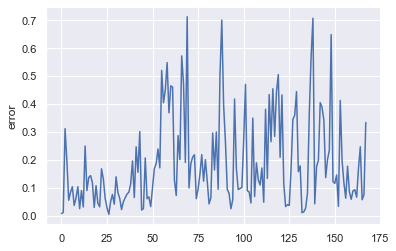

In [155]:
plt.plot(err_list[1:])
plt.ylabel('error')
plt.show()

In [167]:
from tensorflow_core import float32
err_list=[]
for answer in student_answers:
    print(answer.shape)
    answer_tensor = tf.convert_to_tensor(answer,dtype=float32)
    answer_prediction = student_model.predict(answer_tensor)
    x,y,z = answer_prediction.shape
    total=0
    for i in range(y):
        total=abs(answer_prediction[0][i][i]-1)+total
    err_list.append(total/y)

(1, 1, 340)
(1, 2, 340)
(1, 3, 340)
(1, 4, 340)
(1, 5, 340)
(1, 6, 340)
(1, 7, 340)
(1, 8, 340)
(1, 9, 340)
(1, 10, 340)
(1, 11, 340)
(1, 12, 340)
(1, 13, 340)
(1, 14, 340)
(1, 15, 340)
(1, 16, 340)
(1, 17, 340)
(1, 18, 340)
(1, 19, 340)
(1, 20, 340)
(1, 21, 340)
(1, 22, 340)
(1, 23, 340)
(1, 24, 340)
(1, 25, 340)
(1, 26, 340)
(1, 27, 340)
(1, 28, 340)
(1, 29, 340)
(1, 30, 340)
(1, 31, 340)
(1, 32, 340)
(1, 33, 340)
(1, 34, 340)
(1, 35, 340)
(1, 36, 340)
(1, 37, 340)
(1, 38, 340)
(1, 39, 340)
(1, 40, 340)
(1, 41, 340)
(1, 42, 340)
(1, 43, 340)
(1, 44, 340)
(1, 45, 340)
(1, 46, 340)
(1, 47, 340)
(1, 48, 340)
(1, 49, 340)
(1, 50, 340)
(1, 51, 340)
(1, 52, 340)
(1, 53, 340)
(1, 54, 340)
(1, 55, 340)
(1, 56, 340)
(1, 57, 340)
(1, 58, 340)
(1, 59, 340)
(1, 60, 340)
(1, 61, 340)
(1, 62, 340)
(1, 63, 340)
(1, 64, 340)
(1, 65, 340)
(1, 66, 340)
(1, 67, 340)
(1, 68, 340)
(1, 69, 340)
(1, 70, 340)
(1, 71, 340)
(1, 72, 340)
(1, 73, 340)
(1, 74, 340)
(1, 75, 340)
(1, 76, 340)
(1, 77, 340)
(1, 78, 

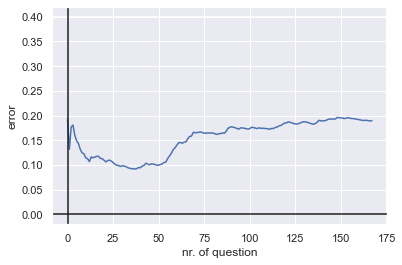

In [203]:
plt.plot(err_list[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0.4, color='w')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

In [51]:
def random_student_question(answer_list_random,question):
    dummy_input=np.zeros((1,question,340))
    for i in range (question):
        dummy_input[0][i][2*answer_list_random[i]+1] = 1
    return dummy_input


In [84]:
import random
indexes = random.sample(range(0,170),169)
indexes

[41,
 163,
 112,
 122,
 156,
 92,
 54,
 77,
 113,
 107,
 167,
 30,
 71,
 3,
 111,
 23,
 33,
 117,
 148,
 135,
 38,
 165,
 73,
 114,
 85,
 40,
 39,
 53,
 143,
 125,
 47,
 64,
 69,
 139,
 1,
 106,
 120,
 140,
 12,
 152,
 138,
 14,
 149,
 119,
 86,
 83,
 84,
 155,
 82,
 76,
 11,
 49,
 6,
 2,
 128,
 48,
 19,
 131,
 133,
 103,
 93,
 21,
 59,
 154,
 102,
 22,
 160,
 141,
 55,
 17,
 161,
 70,
 89,
 100,
 79,
 66,
 5,
 74,
 24,
 159,
 4,
 75,
 9,
 46,
 162,
 90,
 146,
 68,
 57,
 88,
 115,
 36,
 153,
 52,
 137,
 35,
 95,
 78,
 81,
 118,
 60,
 72,
 97,
 27,
 91,
 169,
 26,
 127,
 132,
 25,
 116,
 0,
 34,
 16,
 31,
 51,
 32,
 121,
 164,
 94,
 157,
 168,
 7,
 63,
 10,
 123,
 145,
 20,
 29,
 150,
 130,
 101,
 58,
 158,
 110,
 65,
 42,
 129,
 61,
 124,
 134,
 50,
 8,
 45,
 108,
 96,
 15,
 13,
 151,
 37,
 166,
 109,
 87,
 104,
 67,
 147,
 18,
 144,
 44,
 99,
 142,
 56,
 80,
 98,
 136,
 43,
 126,
 62,
 105]

In [85]:
student_answers_random=[]
for i in range(1,170):
    temp_input=random_student_question(indexes,i)
    student_answers_random.append(temp_input)
print(len(student_answers_random))

169


In [86]:
err_list_random=[]
for i,answer in enumerate (student_answers_random):
    print(indexes[i],i)
    answer_tensor = tf.convert_to_tensor(answer,dtype=float32)
    answer_prediction = student_model.predict(answer_tensor)
    x,y,z = answer_prediction.shape
    err_number=abs(answer_prediction[0][y-1][indexes[i]-1]-1)
    err_list_random.append(err_number)

41 0
163 1
112 2
122 3
156 4
92 5
54 6
77 7
113 8
107 9
167 10
30 11
71 12
3 13
111 14
23 15
33 16
117 17
148 18
135 19
38 20
165 21
73 22
114 23
85 24
40 25
39 26
53 27
143 28
125 29
47 30
64 31
69 32
139 33
1 34
106 35
120 36
140 37
12 38
152 39
138 40
14 41
149 42
119 43
86 44
83 45
84 46
155 47
82 48
76 49
11 50
49 51
6 52
2 53
128 54
48 55
19 56
131 57
133 58
103 59
93 60
21 61
59 62
154 63
102 64
22 65
160 66
141 67
55 68
17 69
161 70
70 71
89 72
100 73
79 74
66 75
5 76
74 77
24 78
159 79
4 80
75 81
9 82
46 83
162 84
90 85
146 86
68 87
57 88
88 89
115 90
36 91
153 92
52 93
137 94
35 95
95 96
78 97
81 98
118 99
60 100
72 101
97 102
27 103
91 104
169 105
26 106
127 107
132 108
25 109
116 110
0 111
34 112
16 113
31 114
51 115
32 116
121 117
164 118
94 119
157 120
168 121
7 122
63 123
10 124
123 125
145 126
20 127
29 128
150 129
130 130
101 131
58 132
158 133
110 134
65 135
42 136
129 137
61 138
124 139
134 140
50 141
8 142
45 143
108 144
96 145
15 146
13 147
151 148
37 149
166 150
1

In [87]:
err_list_random

[0.4775288701057434,
 0.42138397693634033,
 0.4254067540168762,
 0.37714511156082153,
 0.41795814037323,
 0.44615137577056885,
 0.2041163444519043,
 0.23351556062698364,
 0.11972266435623169,
 0.3866010904312134,
 0.15332096815109253,
 0.18217402696609497,
 0.8467497527599335,
 0.0008550286293029785,
 0.1930149793624878,
 0.07392001152038574,
 0.11395514011383057,
 0.37889665365219116,
 0.22645652294158936,
 0.04153555631637573,
 0.1755521297454834,
 0.19403553009033203,
 0.2909669876098633,
 0.43848758935928345,
 0.34183329343795776,
 0.18792760372161865,
 0.12567353248596191,
 0.275068461894989,
 0.22000467777252197,
 0.034995436668395996,
 0.036469340324401855,
 0.16403567790985107,
 0.780078798532486,
 0.5779128670692444,
 0.009451031684875488,
 0.06738942861557007,
 0.475117027759552,
 0.7112516164779663,
 0.06124699115753174,
 0.17735075950622559,
 0.3531554937362671,
 0.053211212158203125,
 0.2501335144042969,
 0.3762863874435425,
 0.30605006217956543,
 0.06702518463134766,
 0.0

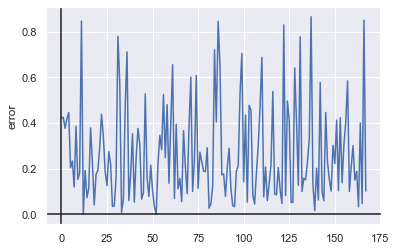

In [88]:
plt.plot(err_list_random[1:])
plt.ylabel('error')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

In [160]:
from tensorflow_core import float32
err_list_random_total=[]
for i,answer in enumerate (student_answers_random):
    answer_tensor = tf.convert_to_tensor(answer,dtype=float32)
    answer_prediction = student_model.predict(answer_tensor)
    x,y,z = answer_prediction.shape
    total=0
    for i in range(y):
        total=abs(answer_prediction[0][i][indexes[i]-1]-1)+total
    err_list_random_total.append(total/y)

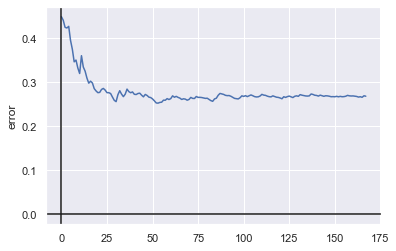

In [90]:
plt.plot(err_list_random_total[1:])
plt.ylabel('error')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

### Scnerio-3

In [50]:
len(indexes)

169

In [103]:
import random
random.sample(range(1, 100), 3)

[52, 67, 26]

In [185]:
def return_sample(begin,end,true_fraction):
    limit_index = int((end-begin)*true_fraction)
    dummy_input=np.zeros((1,170,340))
    dummy_y=np.zeros((170,1))
    indexes = random.sample(range(begin,end),limit_index)
    # print('incorrect')
    # print(indexes)
    # print(len(indexes))
    for i in range(begin,end):
        if i not in indexes:
            dummy_input[0][i][2*i] = 1
            dummy_y[i][0] = 0
        else:
            dummy_input[0][i][2*i+1] = 1
            dummy_y[i][0] = 1
    return dummy_input,dummy_y

In [186]:
# def return_sample(begin,end,true_fraction):
#     limit_index = int((end-begin)*true_fraction)
#     dummy_input=np.zeros((1,170,340))
#     dummy_y=np.zeros((170,1))
#     # indexes = random.sample(range(begin,end),limit_index)
#     # print('incorrect')
#     # print(indexes)
#     # print(len(indexes))
#     for i in range(begin,begin+limit_index):
#         dummy_input[0][i][2*i+1] = 1
#         dummy_y[i][0] = 1
#     for j in range(begin+limit_index,end):
#         dummy_input[0][j][2*j] = 1
#         dummy_y[j][0] = 0
#     return dummy_input,dummy_y

In [187]:
correct_fraction = 0.9

cluster_one_x_true,cluster_one_y_true = return_sample(0,53,correct_fraction)
cluster_two_x_true,cluster_two_y_true = return_sample(53,110,correct_fraction)
cluster_three_x_true,cluster_three_y_true = return_sample(110,170,correct_fraction)


In [188]:
cluster_one_x_false,cluster_one_y_false = return_sample(0,53,1-correct_fraction)
cluster_two_x_false,cluster_two_y_false = return_sample(53,110,1-correct_fraction)
cluster_three_x_false,cluster_three_y_false = return_sample(110,170,1-correct_fraction)

In [189]:
case_1_x = cluster_one_x_false + cluster_two_x_false + cluster_three_x_false
case_1_y = cluster_one_y_false + cluster_two_y_false + cluster_three_y_false

case_2_x = cluster_one_x_true + cluster_two_x_false + cluster_three_x_false
case_2_y = cluster_one_y_true + cluster_two_y_false + cluster_three_y_false

case_3_x = cluster_one_x_false + cluster_two_x_true + cluster_three_x_false
case_3_y = cluster_one_y_false + cluster_two_y_true + cluster_three_y_false

case_4_x = cluster_one_x_true + cluster_two_x_true + cluster_three_x_false
case_4_y = cluster_one_y_true + cluster_two_y_true + cluster_three_y_false

case_5_x = cluster_one_x_false + cluster_two_x_false + cluster_three_x_true
case_5_y = cluster_one_y_false + cluster_two_y_false + cluster_three_y_true

case_6_x = cluster_one_x_true + cluster_two_x_false + cluster_three_x_true
case_6_y = cluster_one_y_true + cluster_two_y_false + cluster_three_y_true

case_7_x = cluster_one_x_false + cluster_two_x_true + cluster_three_x_true
case_7_y = cluster_one_y_false + cluster_two_y_true + cluster_three_y_true

case_8_x = cluster_one_x_true + cluster_two_x_true + cluster_three_x_true
case_8_y = cluster_one_y_true + cluster_two_y_true + cluster_three_y_true

In [190]:
# from tensorflow_core import float32
# case_1_predicted_tensor = tf.convert_to_tensor(case_1_x,dtype=float32)
# case_1_prediction_expanded = tf.expand_dims(case_1_predicted_tensor, axis=0)
# case_1_prediction = student_model.predict(tf.squeeze(case_1_prediction_expanded,axis=0))
#
# case_2_predicted_tensor = tf.convert_to_tensor(case_2_x,dtype=float32)
# case_2_prediction_expanded = tf.expand_dims(case_2_predicted_tensor, axis=0)
# case_2_prediction = student_model.predict(tf.squeeze(case_2_prediction_expanded,axis=0))
#
# case_3_predicted_tensor = tf.convert_to_tensor(case_3_x,dtype=float32)
# case_3_prediction_expanded = tf.expand_dims(case_3_predicted_tensor, axis=0)
# case_3_prediction = student_model.predict(tf.squeeze(case_3_prediction_expanded,axis=0))
#
# case_4_predicted_tensor = tf.convert_to_tensor(case_4_x,dtype=float32)
# case_4_prediction_expanded = tf.expand_dims(case_4_predicted_tensor, axis=0)
# case_4_prediction = student_model.predict(tf.squeeze(case_4_prediction_expanded,axis=0))
#
# case_5_predicted_tensor = tf.convert_to_tensor(case_5_x,dtype=float32)
# case_5_prediction_expanded = tf.expand_dims(case_5_predicted_tensor, axis=0)
# case_5_prediction = student_model.predict(tf.squeeze(case_5_prediction_expanded,axis=0))
#
# case_6_predicted_tensor = tf.convert_to_tensor(case_6_x,dtype=float32)
# case_6_prediction_expanded = tf.expand_dims(case_6_predicted_tensor, axis=0)
# case_6_prediction = student_model.predict(tf.squeeze(case_6_prediction_expanded,axis=0))
#
# case_7_predicted_tensor = tf.convert_to_tensor(case_7_x,dtype=float32)
# case_7_prediction_expanded = tf.expand_dims(case_7_predicted_tensor, axis=0)
# case_7_prediction = student_model.predict(tf.squeeze(case_7_prediction_expanded,axis=0))
#
# case_8_predicted_tensor = tf.convert_to_tensor(case_8_x,dtype=float32)
# case_8_prediction_expanded = tf.expand_dims(case_8_predicted_tensor, axis=0)
# case_8_prediction = student_model.predict(tf.squeeze(case_8_prediction_expanded,axis=0))

In [191]:
case_1_x

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]])

In [192]:
def cases_error (case_x,case_y):
    case_x_error=[]
    for i in range (170):
        answer_tensor = tf.convert_to_tensor(case_x[0][0:i+1].reshape((1,i+1,340)),dtype=float32)
        answer_prediction = student_model.predict(answer_tensor)
        x,y,z = answer_prediction.shape
        total=0
        for j in range(y):
            total=abs(answer_prediction[0][j][j]-case_y[j])+total
        case_x_error.append(total/y)
    return case_x_error


In [193]:
case_x1_error=[]
for i in range (170):
    answer_tensor = tf.convert_to_tensor(case_1_x[0][0:i+1].reshape((1,i+1,340)),dtype=float32)
    answer_prediction = student_model.predict(answer_tensor)
    print(answer_prediction.shape)
    x,y,z = answer_prediction.shape
    total=0
    for j in range(y):
        total=abs(answer_prediction[0][j][j]-case_1_y[j])+total
    case_x1_error.append(total/y)
    #print("err->",err_number,"sample",i)

(1, 1, 170)
(1, 2, 170)
(1, 3, 170)
(1, 4, 170)
(1, 5, 170)
(1, 6, 170)
(1, 7, 170)
(1, 8, 170)
(1, 9, 170)
(1, 10, 170)
(1, 11, 170)
(1, 12, 170)
(1, 13, 170)
(1, 14, 170)
(1, 15, 170)
(1, 16, 170)
(1, 17, 170)
(1, 18, 170)
(1, 19, 170)
(1, 20, 170)
(1, 21, 170)
(1, 22, 170)
(1, 23, 170)
(1, 24, 170)
(1, 25, 170)
(1, 26, 170)
(1, 27, 170)
(1, 28, 170)
(1, 29, 170)
(1, 30, 170)
(1, 31, 170)
(1, 32, 170)
(1, 33, 170)
(1, 34, 170)
(1, 35, 170)
(1, 36, 170)
(1, 37, 170)
(1, 38, 170)
(1, 39, 170)
(1, 40, 170)
(1, 41, 170)
(1, 42, 170)
(1, 43, 170)
(1, 44, 170)
(1, 45, 170)
(1, 46, 170)
(1, 47, 170)
(1, 48, 170)
(1, 49, 170)
(1, 50, 170)
(1, 51, 170)
(1, 52, 170)
(1, 53, 170)
(1, 54, 170)
(1, 55, 170)
(1, 56, 170)
(1, 57, 170)
(1, 58, 170)
(1, 59, 170)
(1, 60, 170)
(1, 61, 170)
(1, 62, 170)
(1, 63, 170)
(1, 64, 170)
(1, 65, 170)
(1, 66, 170)
(1, 67, 170)
(1, 68, 170)
(1, 69, 170)
(1, 70, 170)
(1, 71, 170)
(1, 72, 170)
(1, 73, 170)
(1, 74, 170)
(1, 75, 170)
(1, 76, 170)
(1, 77, 170)
(1, 78, 

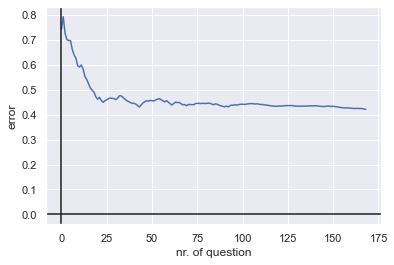

In [205]:
error_1=cases_error(case_1_x,case_1_y)
plt.plot(error_1[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

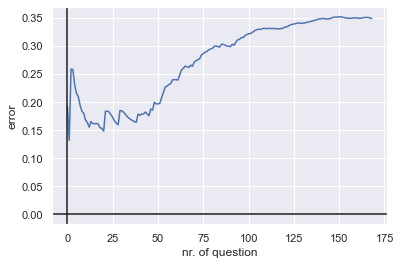

In [206]:
error_2=cases_error(case_2_x,case_2_y)
plt.plot(error_2[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

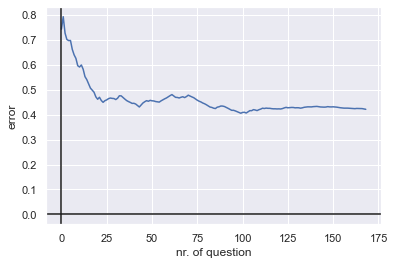

In [207]:
error_3=cases_error(case_3_x,case_3_y)
plt.plot(error_3[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

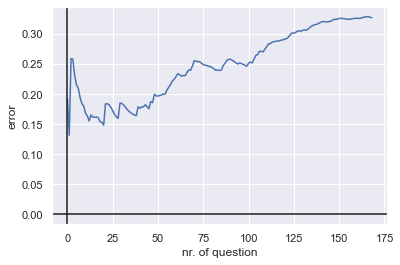

In [208]:
error_4=cases_error(case_4_x,case_4_y)
plt.plot(error_4[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

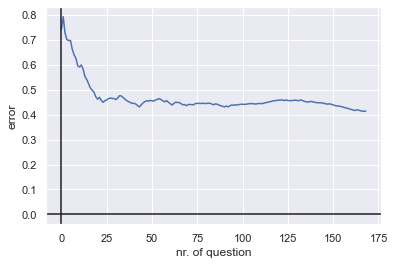

In [210]:
error_5=cases_error(case_5_x,case_5_y)
plt.plot(error_5[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

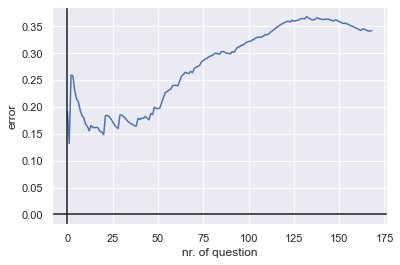

In [211]:
error_6=cases_error(case_6_x,case_6_y)
plt.plot(error_6[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

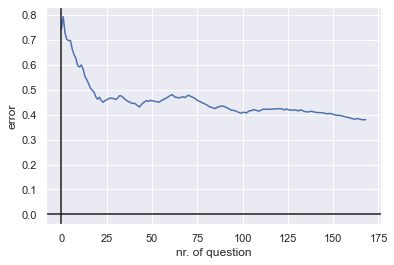

In [212]:
error_7=cases_error(case_7_x,case_7_y)
plt.plot(error_7[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

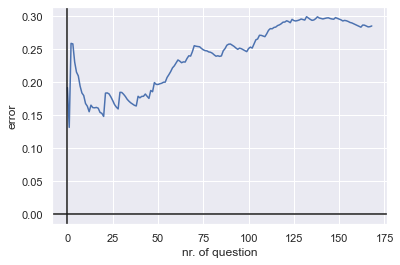

In [213]:
error_8=cases_error(case_8_x,case_8_y)
plt.plot(error_8[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()

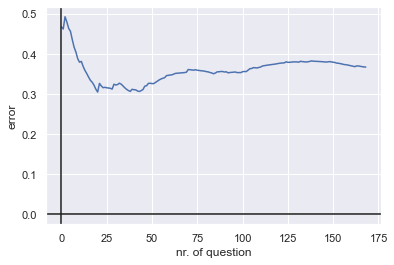

In [214]:

error_cases_total= np.array(error_1)+np.array(error_2)+np.array(error_3)+np.array(error_4)+np.array(error_5)+np.array(error_6)+np.array(error_7)+np.array(error_8)
error_cases_total_result=error_cases_total/8
plt.plot(error_cases_total_result[1:])
plt.ylabel('error')
plt.xlabel('nr. of question')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.show()


In [146]:
case_y2=[]
case_x2=[]
for i in range(170):
    err_number=sum(abs(case_2_prediction[0][i].reshape((170,1))-case_2_y))/170
    case_y2.append(err_number)
    case_x2.append(i)
    #print("err->",err_number,"sample",i)

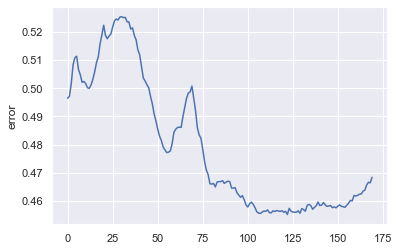

In [147]:
plt.plot(case_x2,case_y2)
plt.ylabel('error')
plt.show()

#### Part 9: Predict only one student from Desired Data Set

In [14]:
student_prediction=tf.expand_dims(predictedTensor, axis=0)

In [15]:
prediction_of_one_student=student_model.predict(tf.squeeze(student_prediction,axis=0))[0]
print(prediction_of_one_student.shape) #This is how the prediction output looks like
print(tf.squeeze(student_prediction,axis=0).shape)#this is how the input looks like see paper intuition doubling the skill_size
prediction_of_one_student[10] #prediction of last time step

(170, 170)
(1, 170, 340)


array([0.95075274, 0.99999523, 0.9998394 , 0.7623473 , 0.8026205 ,
       0.9740617 , 0.94148064, 0.9399883 , 0.96881115, 0.91979146,
       0.8751735 , 0.97477293, 0.9035233 , 0.9374162 , 0.5475346 ,
       0.7944511 , 0.73661566, 0.6579166 , 0.7030196 , 0.86756855,
       0.53079677, 0.7695028 , 0.801406  , 0.3393343 , 0.5529065 ,
       0.911783  , 0.9159709 , 0.96605337, 0.87732786, 0.739063  ,
       0.90689784, 0.65872025, 0.8834579 , 0.8804215 , 0.9207723 ,
       0.7810843 , 0.8200296 , 0.7975786 , 0.76657826, 0.7033586 ,
       0.52631646, 0.7945242 , 0.5137107 , 0.5218361 , 0.31546322,
       0.9324322 , 0.9240488 , 0.5309942 , 0.7959557 , 0.75457203,
       0.8772853 , 0.4910754 , 0.5795051 , 0.62729263, 0.5271449 ,
       0.58068943, 0.18579817, 0.31978795, 0.27575174, 0.336199  ,
       0.1491732 , 0.23301744, 0.14340848, 0.77936053, 0.7465379 ,
       0.38181704, 0.461939  , 0.11847454, 0.11752588, 0.25695366,
       0.04207617, 0.7224198 , 0.40055612, 0.59272003, 0.51325

#### 9.1 Inspect model output error side work

In [34]:
# one to one err
#input is (170)->1
lst_y=[]
lst_x=[]
for i in range(169):
    err_number=abs(prediction_of_one_student[i][i+1]-1)
    lst_y.append(err_number)
    lst_x.append(i)
    #print("err->",err_number,"sample",i)

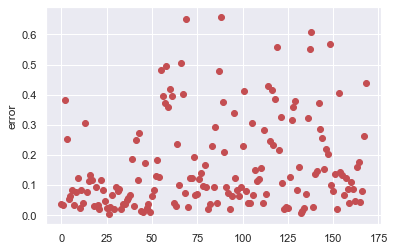

In [35]:
import matplotlib.pyplot as plt
plt.plot(lst_x,lst_y,"ro")
plt.ylabel('error')
plt.show()

In [36]:
lst_y1=[]
lst_x1=[]
for i in range(169):
    err_number=sum(abs(prediction_of_one_student[i][0:i+1]-1))/(i+1)
    lst_y1.append(err_number)
    lst_x1.append(i)
    #print("err->",err_number,"sample",i)

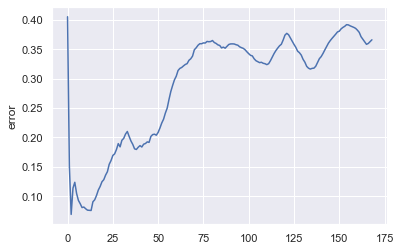

In [37]:
plt.plot(lst_x1,lst_y1)
plt.ylabel('error')
plt.show()

In [38]:
lst_y2=[]
lst_x2=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student[i][0:]-1))/(170)
    lst_y2.append(err_number)
    lst_x2.append(i)
    #print("err->",err_number,"sample",i)

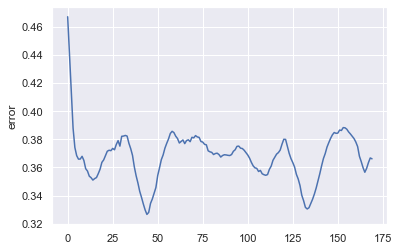

In [39]:
plt.plot(lst_x2,lst_y2)
plt.ylabel('error')
plt.show()

In [40]:
lst_y3=[]
lst_x3=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student[i][i:]-1))/(170-i)
    lst_y3.append(err_number)
    lst_x3.append(i)
    #print("err->",err_number,"sample",i)

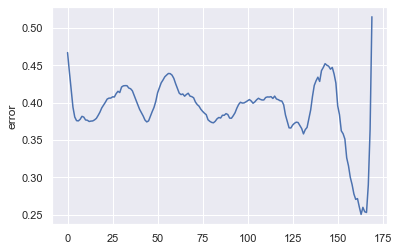

In [41]:
plt.plot(lst_x3,lst_y3)
plt.ylabel('error')
plt.show()

In [42]:
#shuffle the indexes
shuff_indexes=np.arange(170)
np.random.shuffle(shuff_indexes)


In [43]:
#create new
new_prediction=np.zeros((prediction_of_one_student.shape))

In [44]:
#shuffle the predictions
for j,i in enumerate(shuff_indexes):
    #print("j is",j , "i is ",i)
    new_prediction[j]=prediction_of_one_student[i]

In [45]:
lst_y4=[]
lst_x4=[]
for i in range(170):
    err_number=sum(abs(new_prediction[i][0:]-1))/(170)
    lst_y4.append(err_number)
    lst_x4.append(i)
    #print("err->",err_number,"sample",i)

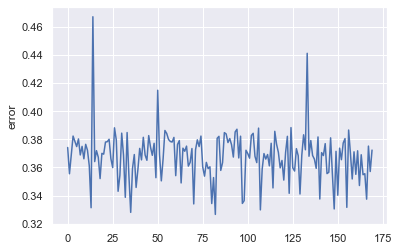

In [46]:
plt.plot(lst_x4,lst_y4)
plt.ylabel('error')
plt.show()

In [47]:
#now lets try giving shuffled input instead of shuffled output
#lets see the result
sample_shuff=np.zeros((1,170,340))
for i,j in enumerate(shuff_indexes):
    sample_shuff[0][i][2*j+1]=1

print("first sample")
print("i=",0,"j=",shuff_indexes[0])
print("value =",sample_shuff[0][0][2*shuff_indexes[0]+1])
#turn it into preper input for the model
shuffTensor=tf.convert_to_tensor(sample_shuff,dtype=float32)
#give input tensor to the  model
shuffTensor=tf.expand_dims(shuffTensor, axis=0)
#shuffled output
prediction_of_one_student_shuffled=student_model.predict(tf.squeeze(shuffTensor,axis=0))[0]


first sample
i= 0 j= 4
value = 1.0


In [48]:
lst_y5=[]
lst_x5=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student_shuffled[i][i:]-1))/(170-i)
    lst_y5.append(err_number)
    lst_x5.append(i)
    #print("err->",err_number,"sample",i)

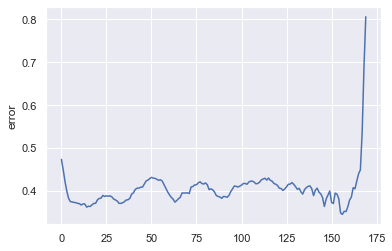

In [49]:
plt.plot(lst_x5,lst_y5)
plt.ylabel('error')
plt.show()

In [50]:
lst_y6=[]
lst_x6=[]
for i in range(170):
    err_number=sum(abs(prediction_of_one_student_shuffled[i][0:]-1))/(170)
    lst_y6.append(err_number)
    lst_x6.append(i)
    #print("err->",err_number,"sample",i)

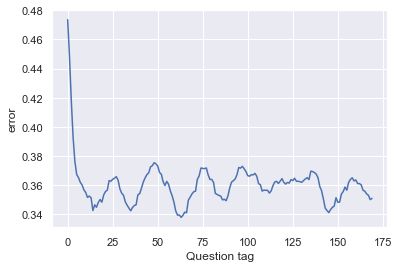

In [51]:
plt.plot(lst_x6,lst_y6)
plt.ylabel('error')
plt.xlabel('Question tag')

plt.show()

### Part 10 Estimate relation

In [18]:
count=170
averages=[]

for i in range (count):
    suma = 0
    for j in range(count):
        suma += prediction_of_one_student[i][j]
    averages.append(suma/count)

In [19]:
relationships = []
for i in range (count):
    relationship = []
    for j in range(count):
        relationship.append(prediction_of_one_student[i][j]/averages[i])
    relationships.append(relationship)

print(len(relationships))
print(len(relationships[0]))

170
170


In [20]:
df = pd.DataFrame(relationships, columns=[i for i in range(170)])

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,1.267953,1.831865,1.666009,1.051965,1.041729,1.108994,1.196528,1.077688,1.171397,1.119226,...,1.010711,1.036150,0.970405,1.012744,1.001436,1.016131,0.990004,1.006732,0.889088,0.825938
1,1.461388,1.853213,1.814803,1.082475,1.131201,1.265358,1.315155,1.093626,1.293293,1.238207,...,1.016933,1.018975,0.944325,1.032958,1.015527,0.994446,1.029183,1.039295,0.809160,0.754643
2,1.571133,1.792583,1.777583,1.123976,1.203081,1.408601,1.394043,1.145780,1.390748,1.317383,...,1.028884,1.007871,0.922537,1.067573,1.035540,0.968733,1.076305,1.052033,0.721933,0.665660
3,1.609791,1.701177,1.697581,1.149458,1.329506,1.518391,1.477586,1.251095,1.481753,1.401868,...,1.061742,1.023861,0.879625,1.113541,1.055077,0.931961,1.145182,1.098918,0.631498,0.557639
4,1.606835,1.662005,1.660218,1.163530,1.350964,1.553729,1.511072,1.291019,1.516272,1.435546,...,1.087188,1.024061,0.860039,1.145347,1.088266,0.907882,1.179437,1.126441,0.569678,0.500935


In [22]:
corr = df.corr()

In [23]:
corr

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,1.000000,0.908166,0.940241,0.902016,0.945040,0.981621,0.991618,0.926370,0.980815,0.958617,...,-0.650384,-0.876370,-0.957960,-0.454375,0.884208,-0.496951,0.083417,-0.142751,-0.838525,-0.355846
1,0.908166,1.000000,0.995305,0.799126,0.784523,0.820011,0.876148,0.777202,0.853004,0.844670,...,-0.830440,-0.861119,-0.906411,-0.721114,0.739910,-0.301168,-0.275362,-0.446415,-0.671569,-0.040228
2,0.940241,0.995305,1.000000,0.829724,0.822629,0.862460,0.909737,0.810604,0.888702,0.875800,...,-0.811139,-0.874998,-0.925306,-0.680698,0.771779,-0.338622,-0.211934,-0.399560,-0.712643,-0.098627
3,0.902016,0.799126,0.829724,1.000000,0.830698,0.902353,0.909991,0.854104,0.902751,0.842681,...,-0.692648,-0.786556,-0.897425,-0.412031,0.773326,-0.517743,0.162828,-0.193155,-0.807682,-0.354543
4,0.945040,0.784523,0.822629,0.830698,1.000000,0.970985,0.962362,0.965371,0.959428,0.973128,...,-0.438677,-0.826516,-0.908170,-0.274804,0.921140,-0.537994,0.262859,0.129823,-0.832257,-0.500173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,-0.496951,-0.301168,-0.338622,-0.517743,-0.537994,-0.563837,-0.497208,-0.543543,-0.452973,-0.420074,...,0.113683,0.506477,0.596764,0.139104,-0.517769,1.000000,-0.097062,-0.326794,0.287755,0.235984
166,0.083417,-0.275362,-0.211934,0.162828,0.262859,0.238542,0.164302,0.265477,0.229394,0.206297,...,0.470552,0.153789,0.044143,0.779935,0.268746,-0.097062,1.000000,0.652280,-0.423888,-0.801255
167,-0.142751,-0.446415,-0.399560,-0.193155,0.129823,0.000132,-0.091446,0.064102,-0.080801,-0.023427,...,0.777100,0.194102,0.189732,0.716038,0.078647,-0.326794,0.652280,1.000000,0.035271,-0.513004
168,-0.838525,-0.671569,-0.712643,-0.807682,-0.832257,-0.876032,-0.881222,-0.886743,-0.909541,-0.872337,...,0.463907,0.680422,0.750828,0.110970,-0.776493,0.287755,-0.423888,0.035271,1.000000,0.661735


In [25]:
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

In [69]:
links_filtered=links.loc[ (links['value'] > 0.9) & (links['var1'] != links['var2']) ]
links_filtered=links_filtered[links_filtered.var1.isnull() == False]
links_filtered=links_filtered[links_filtered.var2.isnull() == False]

links_filtered = links_filtered.sort_values(by=['value'],ascending=False)
links_filtered = links_filtered.groupby('var1').head(3)

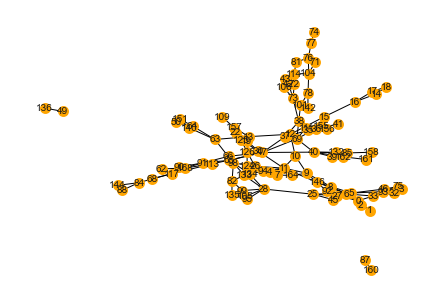

In [70]:
import networkx as nx

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=80, edge_color='black', linewidths=2, font_size=10,pos=nx.spring_layout(G))

In [68]:
A = nx.adjacency_matrix(G)
A.todense()[0]

matrix([[0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

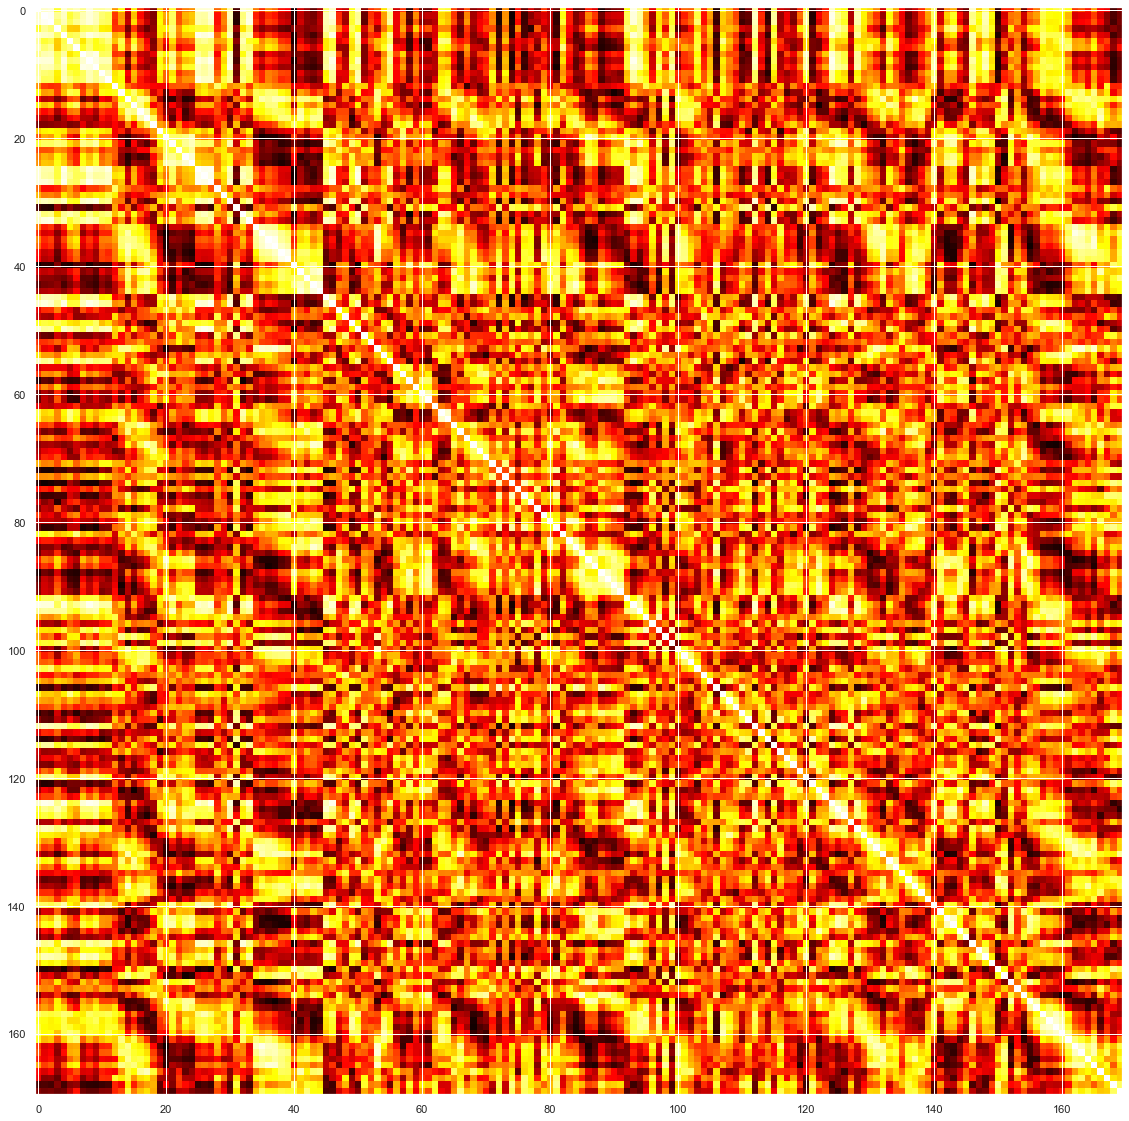

In [101]:
plt.figure(figsize = (20,20))
plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.show()

In [103]:
corr.style.background_gradient(cmap='coolwarm')

In [21]:
def prediction_on_given_data_set(d_set,prediction_set,student_answer_set):
    """
    This function makes prediction
    on given data set
    """
    for data_candidate in d_set:
        prediction_set.append(student_model.predict(data_candidate[0])[0])
        #set index 0 for 246,set 1 for 124
        temp=data_candidate[0]
        student_answer_set.append(temp[0])
    return prediction_set,student_answer_set

In [22]:
data_set_prediction=[]
data_set_student_answer=[]
data_set_prediction,data_set_student_answer=prediction_on_given_data_set(test_set,data_set_prediction,data_set_student_answer)

In [23]:
last_time_step_prediction_bayes=[]
#len(candidate)-1
for candidate in data_set_prediction:
    last_time_step_prediction_bayes.append(candidate[len(candidate)-1])

In [24]:
last_time_step_prediction_bayes=np.array(last_time_step_prediction_bayes)
last_time_step_prediction_bayes.shape

(306, 170)

In [25]:
last_time_step_prediction_bayes_th=np.where(last_time_step_prediction_bayes > 0.5, 1, 0)

In [26]:
last_time_step_prediction_bayes_th.shape

(306, 170)

In [28]:
cols=[]
for c  in range(170):
    strc="s"+ str(c)
    cols.append(strc)
index=[]
for m in range(170):
    stry="i" + str(m)
    index.append(stry)

In [29]:
last_time_step_prediction_bayes_th_df = pd.DataFrame(last_time_step_prediction_bayes_th,
columns=cols)

In [30]:
last_time_step_prediction_bayes_th_df.shape

(306, 170)

In [31]:
last_time_step_prediction_bayes_th_df

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,s160,s161,s162,s163,s164,s165,s166,s167,s168,s169
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,0
2,1,1,1,1,0,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,0
302,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
303,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
304,1,1,1,0,1,1,1,1,1,1,...,1,1,0,0,1,1,1,1,0,0


In [32]:
np.savetxt("last_time_step_mooc_bayes.csv",last_time_step_prediction_bayes_th_df, delimiter=",")

In [ ]:
model_hc_bic  = bn.structure_learning.fit(last_time_step_prediction_bayes_th_df,
                                          methodtype='hc', scoretype='bic',verbose=5,bw_list_method='nodes',
                                          )

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
